In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from forecast_emulator import ForecastEmulator
from utils import nrmse, nmae, eof
from utils import morph_eof, morph_nmae, morph_nrmse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
%load_ext autoreload
%autoreload 2

# Notebook used for development and preliminary tests

The notebook breaks down the main steps of the proposed approach for the generation of tunable forecast profiles.
Overall the methods of the __ForecastEmulator__ class discussed allows to generate a Markov Model, generate forecast
 profiles, befor selecting and tuning (morhping) one scnearios to reach a desired error value.

# 1 - Load input time series from avaiable data
data shall consist on a pd.TimeSerie, ideally more than one month long and with a regular time step

In [3]:
data = pd.read_excel("../data/load_uk_norm.xlsx", index_col=0)
data = data['demand_MW']*6
data

Timestamp
2019-01-01 00:00:00    2.593886
2019-01-01 00:15:00    2.534934
2019-01-01 00:30:00    2.475983
2019-01-01 00:45:00    2.338428
2019-01-01 01:00:00    2.200873
                         ...   
2019-12-31 22:45:00    2.174672
2019-12-31 23:00:00    2.122271
2019-12-31 23:15:00    2.069869
2019-12-31 23:30:00    2.017467
2019-12-31 23:45:00    2.017467
Name: demand_MW, Length: 35040, dtype: float64

# 2 - Create/intialize the emulator
The __ForecastEmulator.__init____ :
- checks that the input __data__ is a valid time serie
- infers a regular time step (in minutes)
- generates the possbile states at each time steps within a day  : __states_maps__
- diretises the input time series along the entire horizons with the sets of states claculated at each daily time step
- generates a state transition matrix at each daily time step for Markov Models : __trans_matrices__


In [4]:
emulator = ForecastEmulator(data, nb_states = 30)

Using the object atrtributes it then possible to plot individual state trnasition matrix for each daily time step
identified with hour and minute -- the function checks that the time steps belongs to the time discretisation

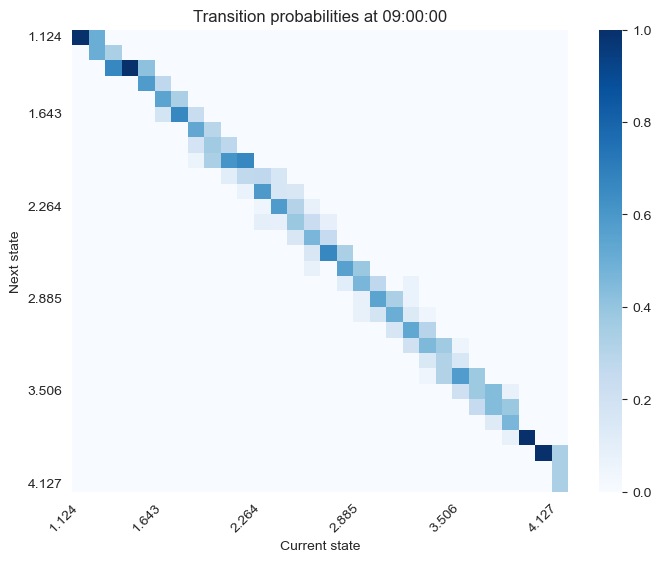

In [5]:
emulator.plot_transition_heatmap(emulator.trans_matrices,
                                 emulator.state_maps,
                                 hour=9, minute =00)

# 3 - Use the emulator to generate profiles and forecast
A method allows to generate several profiles (n_profiles) from a given state (i.e. hour, minute and value) and with a
 given horizon expresse un number of successive time steps from the initial value

Text(0, 0.5, 'Value')

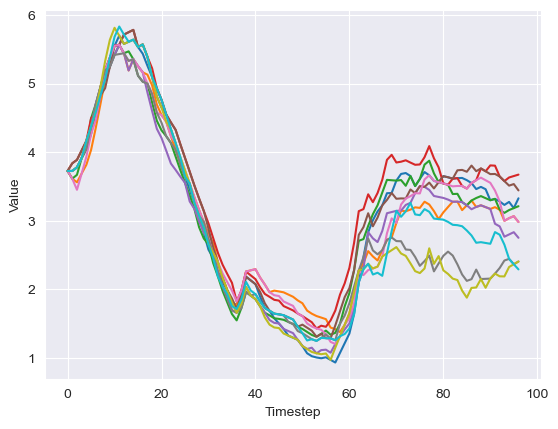

In [6]:
profiles = emulator.generate_profiles(n_profiles = 10,
                                      start_hour = 14,
                                      start_minute = 45,
                                      start_value = 3.68,
                                      n_steps= 97
                                      )
import matplotlib.pyplot as plt
import numpy as np
import plotly.tools as tls

plt.plot(profiles)
plt.xlabel("Timestep")
plt.ylabel("Value")


Every profile can be considered as a forecast relatively to a given reference profile starting at the same time step.
 A method generates profiles as previously and then computes the error with a reference profile
 - __reference__ : an input time serie representing the actual values to forecast along a given horzion. The time
 series can cover a longer period. If not provided, the input time serie used to initialize the emulator is considered
 - __start_time__ : initial datetime for the forecast. The function tests that the start time is within the reference
  data time ranfge. The profiles generated will start from the time step
 immediately before the start time - i.e. last known value in the reference profiles
 - __duration_minutes__ : forecast horzion in minutes. This input is used to compute the number of time steps when
 generating the profiles. Functions automatically infer the time resolution
 - __n_profiles__ : number of profiles to generate
 - __metric__ : error metric to evaluate the profiles (e.g. nrmse, nmae -- see utils)

The function returns the profiles generated in a dataframe, the reference values as a time serie along the forecast
horizon and the errors values in an array


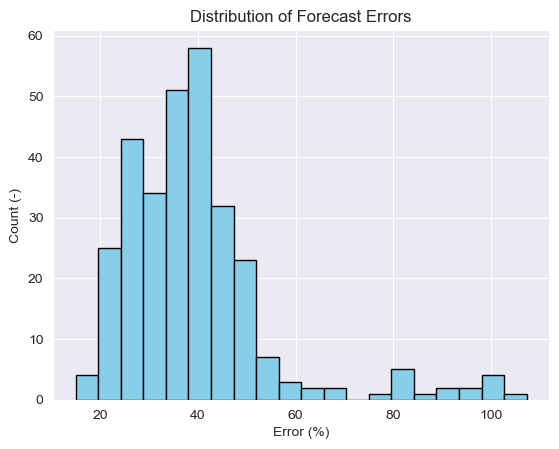

In [7]:
metric_error = 'eof'
profiles,reference,errors = emulator.generate_forecast_profiles(
    reference=None,
    start_time = datetime(2019,1,9,8,0),
    duration_minutes= 60*24,
    n_profiles = 300,
    metric=metric_error
 )

# Plot the distribution of forecast errors
# values along the time horizon for the profiles generated
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Error (%)")
plt.ylabel("Count (-)")
plt.title("Distribution of Forecast Errors")
plt.show()

# 4 - Select a single forecast and tune it
From the forecast profiles generated previously, select a profile based on its error value computed with the metric
choosen (e.g. eof, nrmse or nmae):
- if __selection__ option is __median__ the profile selected displays the median error value
- if __selection__ option is __closest__ the profile selected displays the closest error to a target value.

Once the profile is selected it can be tuned following a morphing function following the error metric chosen in
order to match a target error value. if __selection__ option is __median__ the resulting profile may display more
noise , if __selection__ option is __closest__ the resulting profile may display an offset
 with the selected profile.

!!!RECOMMENDATION!!! is to use __eof__ (Error of Fit) as metric as it displays the widest range in temrs of errors
values for the generated profiles and __closest__ as selection options.

Target Error (%) = 80.00
Selected Profile Error (%) = 80.31
Tuned Profile Error (%) = 80.00


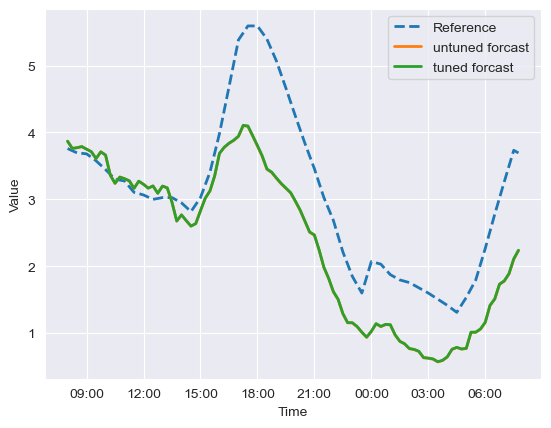

In [8]:
target_error = 80
selected_profile, error_selected_profile = emulator.select_profile(profiles,
                                           errors,
                                           target_error = target_error,
                                           selection = 'closest')

# Tune the profile
from utils import morph_nrmse, morph_nmae, morph_eof, nrmse, nmae, eof
morph_func = {"nrmse": morph_nrmse,"nmae": morph_nmae, 'eof': morph_eof}[metric_error.lower()]
tuned_profile = morph_func(reference.values,selected_profile.values,target_error)
tuned_profile = pd.Series(tuned_profile,index = reference.index)
metric_func = {"nrmse": nrmse,"nmae": nmae, 'eof': eof}[metric_error.lower()]
error_tuned_profile = metric_func(reference.values,tuned_profile.values)

# Display results
print(f"Target Error (%) = {target_error:.2f}")
print(f"Selected Profile Error (%) = {error_selected_profile:.2f}")
print(f"Tuned Profile Error (%) = {error_tuned_profile:.2f}")
plt.plot(reference.index, reference.values, label="Reference", linestyle="--", linewidth=2)
plt.plot(reference.index, selected_profile.values, label='untuned forcast', linewidth=2)
plt.plot(reference.index,tuned_profile.values, label='tuned forcast', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.legend()
plt.show()

Ultimately the methods to generate the profiles, compute the error, select and tune a single profile as forecast are
encaplsualted in a single method __forecast__  with the following inputs

- __reference__ : an input time serie representing the actual values to forecast along a given horzion. The time
 series can cover a longer period. If not provided, the input time serie used to initialize the emulator is considered
 - __start_time__ : initial datetime for the forecast. The function tests that the start time is within the reference
  data time ranfge. The profiles generated will start from the time step
 immediately before the start time - i.e. last known value in the reference profiles
 - __duration_minutes__ : forecast horzion in minutes. This input is used to compute the number of time steps when
 generating the profiles. Functions automatically infer the time resolution
 - __n_profiles__ : number of profiles to generate, if not provided the methods considers the emulator attribute
 __nb_forecast_profiles__
 - __metric__ : error metric to evaluate the profiles (e.g. eof, nrmse, nmae -- see utils)
 - __selection__ : option to select the profile to tune

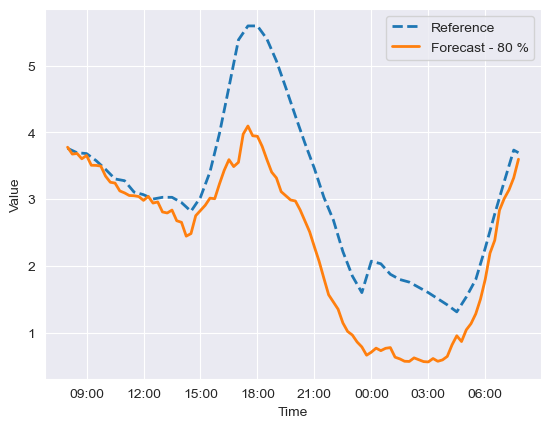

In [9]:
target_error = 80
start_time = datetime(2019,1,9,8,0)

reference, forecast = emulator.forecast( reference=None,
                                        start_time = start_time,
                                        duration_minutes= 60*24,
                                        n_profiles = 300, # optional as already an attribute of the emulator object
                                        metric='eof',
                                        target_error = target_error,
                                        selection = 'closest')

plt.plot(reference.index, reference.values, label="Reference", linestyle="--", linewidth=2)
plt.plot(forecast.index, forecast.values, label=f'Forecast - {target_error:.0f} %', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.legend()
plt.savefig("forecast_chart.svg", format="svg")
plt.show()


# 5 - Misclaenous Tests on Emulator Settings

A first set of preliminary tests loop over the number of states when discretizing the input data. The impact is
assess at the level of the profiles generated ths display smoother bahavious whent the number of states increases.

<Axes: >

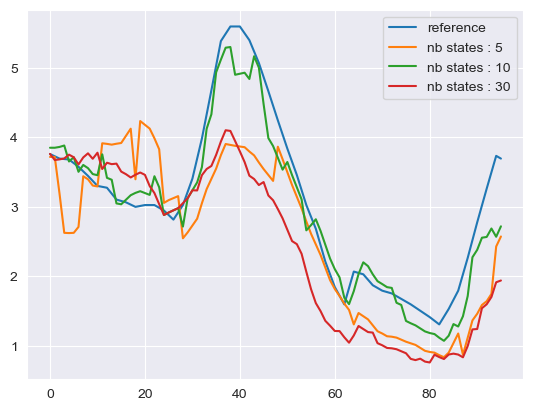

In [10]:
start_time = datetime(2019,1,9,8,0)
n_steps = 96
time_index = [start_time + i*pd.Timedelta(minutes = 15) for i in range(n_steps)]
reference = data.loc[time_index]
df = pd.DataFrame()
df['reference']=reference.values

for nb_states_test in [5, 10, 30] :

    emulator = ForecastEmulator(ts_in = data,
                                nb_states = nb_states_test)

    profile = emulator.generate_profiles(n_profiles = 1,
                                         start_hour = start_time.hour,
                                         start_minute = start_time.minute,
                                         start_value = reference.values[0],
                                         n_steps = 96)

    df[f"nb states : {nb_states_test}"] = profile

df.plot()


A second set of tests illustrates the impact of the numbers of scenarios generated. Especially, the more profiles are
generated, the greater the opportunity to have a wider range of error values with the reference profiles. Hence, it
easier to select a profile that display minimum difference with a given target error value which limits the effect of
 the morphing phase following the selection process.

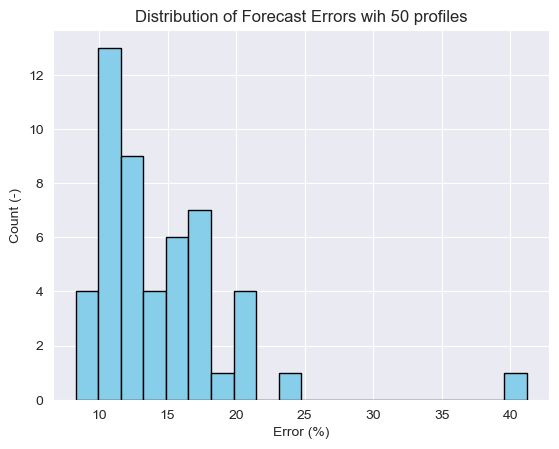

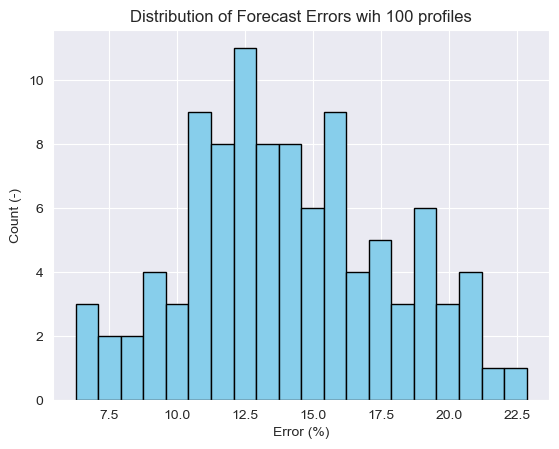

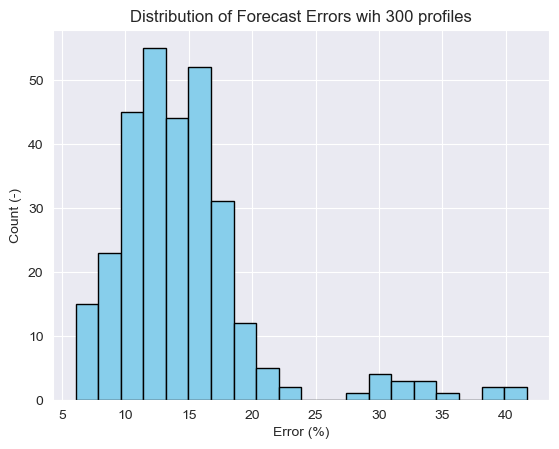

In [11]:
for n_profiles in [50,100,300]:

    metric_error = 'nrmse'
    profiles,reference,errors = emulator.generate_forecast_profiles(
        reference=None,
        start_time = datetime(2019,1,9,8,0),
        duration_minutes= 60*24,
        n_profiles = n_profiles,
        metric=metric_error
     )

    plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel("Error (%)")
    plt.ylabel("Count (-)")
    plt.title(f"Distribution of Forecast Errors wih {n_profiles} profiles")
    plt.show()


Ultimately, the two main parameters of the tool are the number of states when discretizing the original time
series and the number of profiles generated when emulating forecast. A serie of states investigate the computational
times to generate a forecast profile and for different emulator settings.


In [12]:
import time
from tqdm import tqdm
import warnings

results=[]

nb_states_list = [5, 30]
nb_profiles_list = [50, 300]
nb_steps_list = [2, 4, 8, 16, 32, 48, 96, 144, 288]
total = len(nb_states_list)*len(nb_profiles_list)*len(nb_steps_list)


with tqdm(total = total) as pbar:
    for nb_states in  nb_states_list :
        for nb_profiles in  nb_profiles_list:

            emulator = ForecastEmulator(ts_in = data,
                                        nb_states = nb_states,
                                        nb_forecast_profiles=  nb_profiles)

            for nb_steps in nb_steps_list:

                start_t = time.time()

                ref, forecast = emulator.forecast(start_time = datetime(2019,1,1,18,0),
                                                  duration_minutes  = 15*nb_steps, #original data had 15 min time step
                                                  target_error = 10)  #no impact of target error
                duration = time.time() - start_t

                results.append({'nb_states' : nb_states,
                                'nb_profiles' : nb_profiles,
                                'nb_steps' : nb_steps,
                                'cpu_time': duration*1000})

                pbar.update(1)

results=pd.DataFrame(results)

100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


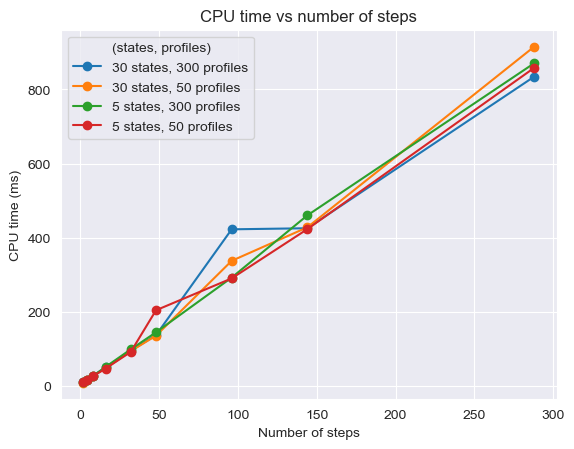

In [13]:
# Create a column for the combination
results["combination"] = results["nb_states"].astype(str) + " states, " + results["nb_profiles"].astype(str) + " profiles"

# Pivot so each combination becomes a column
pivot_df = results.pivot_table(
    index="nb_steps",
    columns="combination",
    values="cpu_time"
)

# Plot
pivot_df.plot(marker="o")
plt.xlabel("Number of steps")
plt.ylabel("CPU time (ms)")
plt.title("CPU time vs number of steps")
plt.legend(title="(states, profiles)")
plt.show()

# 6 - Illustrative Forecasts
The next set of tests illustrates the outputs of the tools for different types of timeseries :
- Load profiles - residential district consumption (kW) - 15 min resolution / 2019 from  __../data/load_uk_norm.xlsx__
- Solar generation profiles - solar pannels output power (kW) - 15 min resolution / 2019 from __'../data/pv_uk_norm
.xlsx'__
- Electriciyy prices - day-ahead prices (€/MWh) - 1h resolution / 2021

In [14]:
# Load Profiles
from data import load_sample_data
emulator = ForecastEmulator(load_sample_data,
                            nb_states = 30,
                            nb_forecast_profiles = 300)

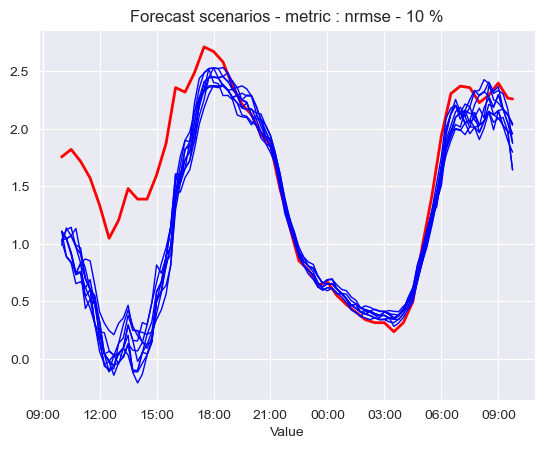

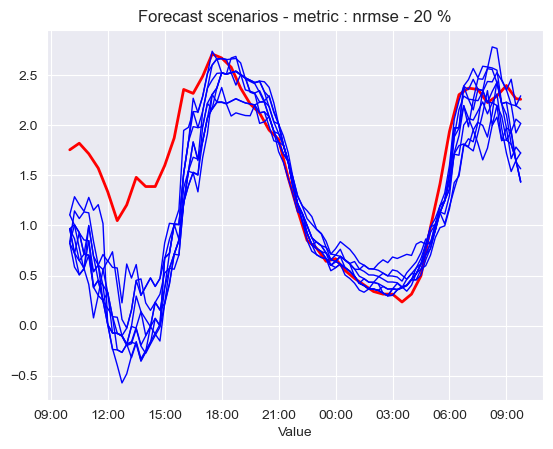

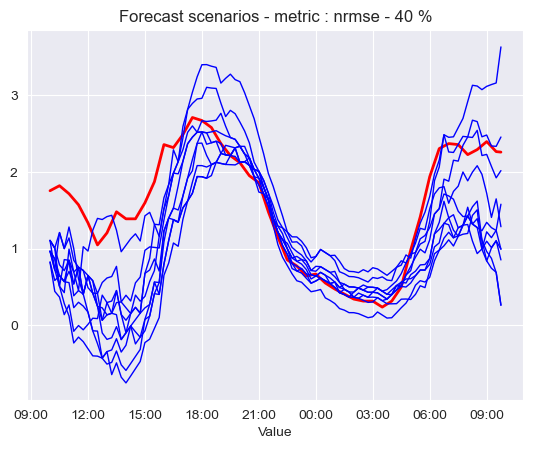

In [23]:
n_runs = 10
error_test = [10, 20, 40 ]
error_metric = 'nrmse'
start_time=datetime(2019,6,25,10,0)
duration_minutes  = 60*24
reference=load_sample_data.loc[start_time:start_time+pd.Timedelta(minutes = duration_minutes)].iloc[:-1]

for target_error in error_test:

    plt.plot(reference.index, reference.values, label='Ref', color='red', linewidth=2)
    plt.xlabel('Timestep')
    plt.xlabel('Value')
    plt.title(f'Forecast scenarios - metric : {error_metric} - {target_error} %')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    for run in range(n_runs):
        ref, forecast = emulator.forecast(start_time = start_time,
                                                  duration_minutes  = duration_minutes, #original data had 15 min time step
                                                  target_error = target_error)  #no impact of target error

        plt.plot(reference.index, forecast.values, color='blue', linewidth=1)

    plt.show()

In [16]:
from data import pv_sample_data
emulator = ForecastEmulator(pv_sample_data,
                            nb_states = 30,
                            nb_forecast_profiles = 300)

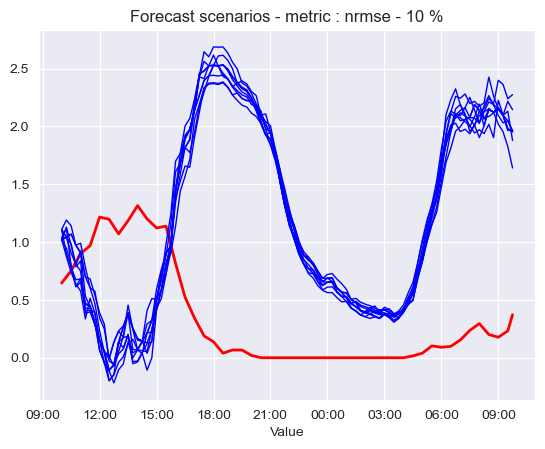

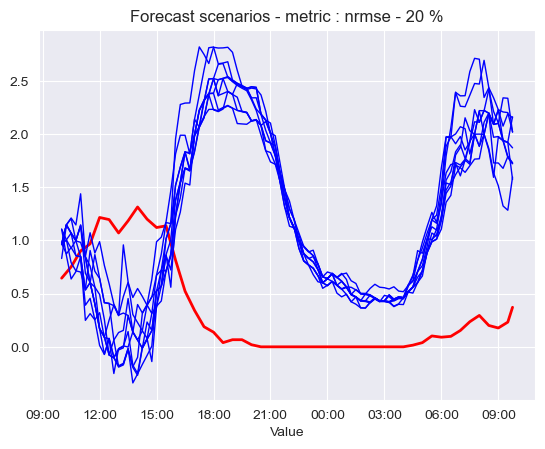

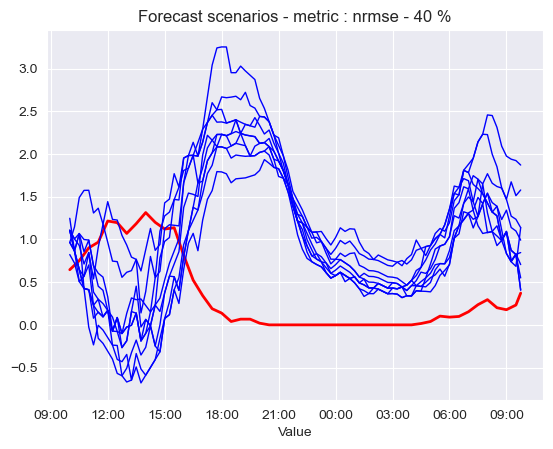

In [24]:
n_runs = 10
error_test = [10, 20, 40 ]
error_metric = 'nrmse'
start_time=datetime(2019,6,25,10,0)
duration_minutes  = 60*24
reference=pv_sample_data.loc[start_time:start_time+pd.Timedelta(minutes = duration_minutes)].iloc[:-1]

for target_error in error_test:

    plt.plot(reference.index, reference.values, label='Ref', color='red', linewidth=2)
    plt.xlabel('Timestep')
    plt.xlabel('Value')
    plt.title(f'Forecast scenarios - metric : {error_metric} - {target_error} %')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    for run in range(n_runs):
        ref, forecast = emulator.forecast(start_time = start_time,
                                                  duration_minutes  = duration_minutes, #original data had 15 min time step
                                                  target_error = target_error)  #no impact of target error

        plt.plot(reference.index, forecast.values, color='blue', linewidth=1)

    plt.show()


In [26]:
from data import price_sample_data
emulator = ForecastEmulator(price_sample_data,
                            nb_states = 60,
                            nb_forecast_profiles = 300)

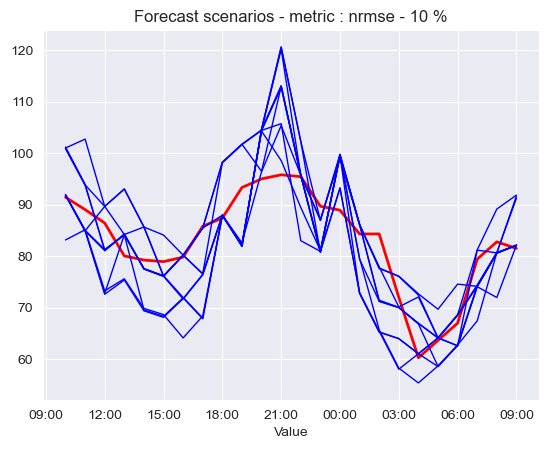

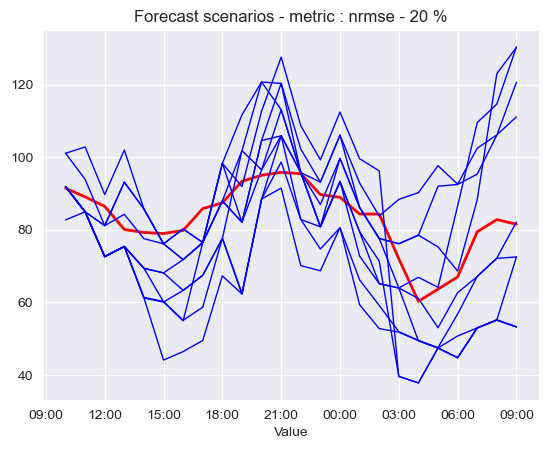

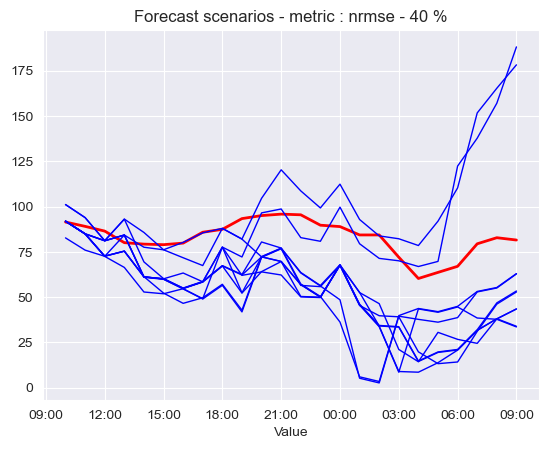

In [27]:
n_runs = 10
error_test = [10, 20, 40 ]
error_metric = 'nrmse'
start_time=datetime(2021,6,25,10,0)
duration_minutes  = 60*24
reference=price_sample_data.loc[start_time:start_time+pd.Timedelta(minutes = duration_minutes)].iloc[:-1]

for target_error in error_test:

    plt.plot(reference.index, reference.values, label='Ref', color='red', linewidth=2)
    plt.xlabel('Timestep')
    plt.xlabel('Value')
    plt.title(f'Forecast scenarios - metric : {error_metric} - {target_error} %')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    for run in range(n_runs):
        ref, forecast = emulator.forecast(start_time = start_time,
                                                  duration_minutes  = duration_minutes, #original data had 15 min time step
                                                  target_error = target_error)  #no impact of target error

        plt.plot(reference.index, forecast.values, color='blue', linewidth=1)

    plt.show()


# 7 - Forecast Accuracy Vs Horzion

Some applications in the energy sector rely on operational planning where decisions are based on real-time forecast.
Typical predictive control strategies then proceed in a rolling window fashions with forecast updated regularly (see
 __ems_rolling__). The underlying idea is that, with updated forecast, the accuracy of the predictions is
 improved, especially for the immediate time step following the forecast. A last serie of tests then consist in
 random forecast of a given time series (i.e. with different starting points). In every case the forecast are 24h
 long and the error is computed at different time horizons - 2h 4h 8h and 24h The results show that the proposed
 emulator display an expected behaviour with better accuracy on the short term.

In [28]:
net_load = load_sample_data-pv_sample_data  #same as for the energy management strategy in ems_power_smoothing

# Initialize the forecast emulator
emulator = ForecastEmulator(ts_in = net_load,
                            nb_states = 30,
                            nb_forecast_profiles =300)

In [29]:
import random
from datetime import datetime,timedelta

start_time = datetime(2019,1,1,0,0)
end_time = datetime(2019,7,1,0,0)
error_metric = 'nrmse'
metric_func = {"nrmse": nrmse,"nmae": nmae, 'eof': eof}[error_metric.lower()]

Ndates = 20
error_targets = np.linspace(10,50,5)

# build all possible datetimes at 15min steps
max_start = end_time - timedelta(hours = 24)  # last start time possible
all_times = pd.date_range(start_time,max_start,freq = "15min")
rand_starts = random.sample(list(all_times),Ndates)

horizons = [2,4,8,24]
results = []

total_runs = Ndates * len(error_targets)
run_id = 0

with tqdm(total = total_runs,desc = "Simulations") as pbar:
    for st in rand_starts:
        for et in error_targets:
            run_id += 1

            reference,forecast = emulator.forecast(start_time = st,
                                                   duration_minutes = 60 * 24,
                                                   metric = error_metric,
                                                   target_error = et,
                                                   selection = 'closest'
                                                   )

            row = {'run': run_id,'error_target': et}
            for h in horizons:
                nsteps = int(h) * 4 #15 min time steps
                row[f'error_{h}h'] = metric_func(reference.values[:nsteps],forecast.values[:nsteps])
            results.append(row)

            pbar.update(1)

df = pd.DataFrame(results)

Simulations: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


<Axes: >

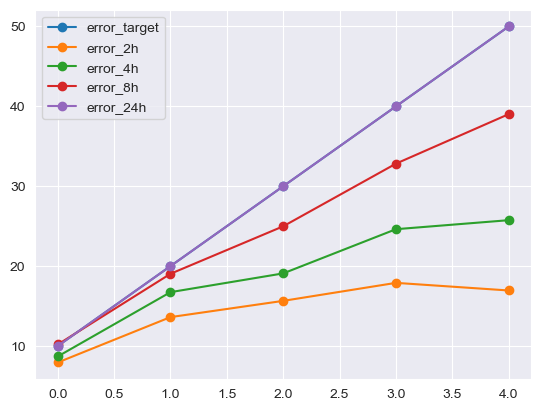

In [30]:
df_mean = df.groupby('error_target').mean(numeric_only = True).reset_index()
df_mean.drop(columns=["run"], inplace=True)
# df_mean.set_index(df_mean.columns[0])
df_mean.plot(marker='o')
